>> 1 하이퍼파라미터

1. Parameter는 데이터를 통해 모델 내부에서 변경되는 값이다. 
딥러닝에서는 Layer의 Weight와 Bais들이 parameter이며, model.summary()를 통해 

아래 예시처럼 파라미터 개수를 확인 할 수 있다

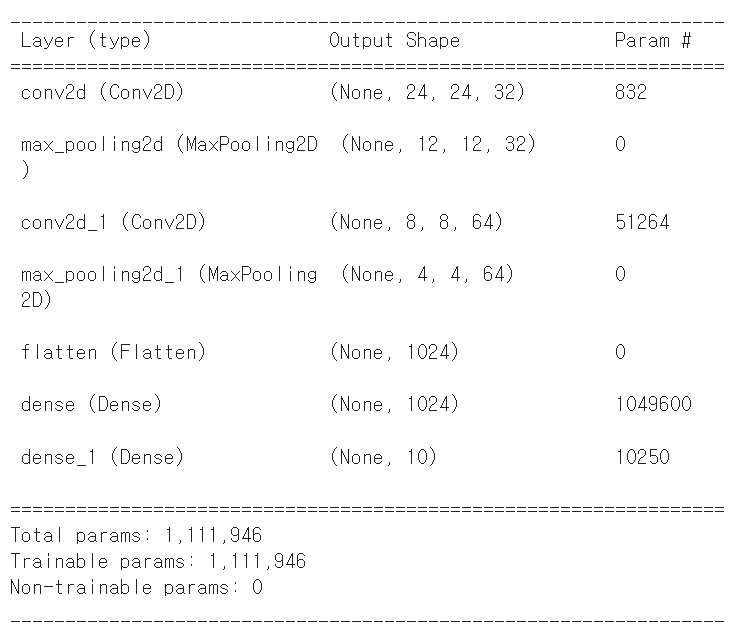

In [37]:
from IPython.display import Image
Image('/content/drive/MyDrive/AI_한기대/images/6_model parameter.png', width = 400)

2. Hyper Parameter: 모델의 학습에 영향을 미치는 parameter이며, 우리가 모델 학습 시에 직접 입력하는 parameter를 의미한다. 

* Parameter는 데이터를 기반으로 모델 내부에서 알고리즘에 의해 변하는 값
  - model.summary()를 통해 확인할 수 있음

* Layer와 관련된 Hyper Parameter
  - Dense Layer의 Unit의 개수
  - Convoluiton Layer의 Kernel Size
  - Dropout Layer의 비율

* 모델 컴파일과 관련된 요소
  - Optimizer의 학습률
  - Batch Size 

Hyper Parameter의 설정은 학습 모델의 성능에 영향을 미치며, 최적의 Hyper Parameter를 구하기 위해 아래와 같은 다양한 방법들이 사용된다. 

다양한 Hyper parameter의 조합을 테스트해서 가장 좋은 조합을 찾는 방법들임
* grid search, random search, hyperband 등이 있음 

>> 2 Keras-Tuner

Keras Tuner를 활용하여 Hyper parameter tuning을 진행해보겠습니다. 

In [1]:
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


저장된 모델을 불러옵니다. 

In [3]:
model_trained = tf.keras.models.load_model('/content/drive/MyDrive/AI_한기대/cnn_checkpoint.h5')

데이터를 학습할 때와 동일하게 표준화 및 One-hot Encoding 합니다

In [4]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
# train set 에서 10000개를 validation set으로 나눔
x_val, y_val = x_train[50000:,:], y_train[50000:]   # 50000~59999까지 validation으로 나눔
x_train, y_train = x_train[:50000, :], y_train[:50000] # 0~49999까지 train set으로 저장

In [6]:
import numpy as np
mean = np.mean(x_train, axis=0)  

In [7]:
std = np.std(x_train)  # 표준편차를 계산합니다. 
x_train_centered = (x_train-mean)/std
x_val_centered = (x_val-mean)/std
x_test_centered = (x_test-mean)/std

In [8]:
# one hot encoding
from tensorflow.keras.utils import to_categorical

y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

In [9]:
model_trained.evaluate(x_test, y_test_onehot )

313/313 [==============================] - 11s 3ms/step - loss: 4.9598 - acc: 0.9822


[4.959763526916504, 0.982200026512146]

In [11]:
model_trained.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1

Hyper Parameter 조정을 통해 성능을 향상해봅시다. 

하이퍼 파라미터는 학습 모델의 성능에 영향을 미치는 Parameter를 의미합니다. 

* 레이어는 Unit 수, Kernel size, 학습률 등 다양한 값들이 학습 성능에 영향을 미치게 됩니다. 

여기에서는 Dense Layer의 Unit의 개수를 변경하여 최적의 값을 찾아보겠습니다. 


Keras Tuner를 통해서 이러한 값들을 바꾸면서 성능을 테스트할 수 있습니다. 

In [13]:
# keras tuner 설치

!pip install -q -U keras-tuner

모델의 Hyperparameter를 바꿔가면서 학습하고 비교하기 때문에 여러개의 모델을 만들 수 있도록 모델을 만드는 함수를 만듭니다. 
* 하이퍼 파라미터를 입력받을 수 있게 입력 변수를 넣어줍니다
* 함수는 모델을 반환하도록 만듭니다

원래의 모델을 참고하여 함수를 만듭니다
```
  model = models.Sequential()
  model.add(layers.Conv2D(32,(5,5), padding='valid', activation='relu', input_shape=(28,28,1)))
  model.add(layers.MaxPool2D(2,2))
  model.add(layers.Conv2D(64,(5,5), padding='valid', activation='relu'))
  model.add(layers.MaxPool2D(2,2))
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
```

keras tuner에는 정수값을 일정 간격으로 바꿔가면서 테스트할 수 있는 Int()와 
리스트 값에서 바꿔가면서 선택할 수 있는 Choice()가 있습니다. 

Dense Layer Unit 개수는 512개에서 2048개까지 128씩 차이나도록 테스트해보겠습니다. 

학습률은 Choice를 통해서 변경해보겠습니다

In [19]:
from tensorflow.keras import models, layers

In [20]:
def model_builder(hp):
  model = models.Sequential()
  model.add(layers.Conv2D(32,(5,5), padding='valid', activation='relu', input_shape=(28,28,1)))
  model.add(layers.MaxPool2D(2,2))
  model.add(layers.Conv2D(64,(5,5), padding='valid', activation='relu'))
  model.add(layers.MaxPool2D(2,2))
  model.add(layers.Flatten())

  # dense1의 unit 개수를 변수로 변경
  dense1_units = hp.Int('units', min_value = 512, max_value = 2048, step = 128)  
  model.add(layers.Dense(dense1_units, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))

  # Adam Optimizer 학습률 선택지
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

  # Optimizer에 학습률 변수를 넣기 위해서 keras.optimizers.Adam 사용
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss='categorical_crossentropy', 
                metrics = ['accuracy'])
  return model

keras tuner의 random search를 통해 최적값을 찾아봅시다. 

In [21]:
# 인스턴스 만들기

import kerastuner as kt
tuner = kt.RandomSearch(model_builder,
                     objective = 'val_accuracy', 
                     max_trials = 10)  

이제 여러 조합의 결과를 탐색해봅니다. 
모델을 여러번 학습하면서 결과를 비교하므로 한번 학습하는 것보다 시간이 오래 걸립니다. 

In [24]:
tuner.search(x_train, y_train_onehot, epochs = 10, validation_data = (x_test, y_test_onehot))

Trial 10 Complete [00h 01m 10s]
val_accuracy: 0.989300012588501

Best val_accuracy So Far: 0.989300012588501
Total elapsed time: 00h 13m 36s
INFO:tensorflow:Oracle triggered exit


가장 좋은 파라미터 값을 가져옵니다

In [25]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [27]:
best_hps.values

{'learning_rate': 0.0001, 'units': 896}

가장 좋은 파라미터 값으로 모델을 만듭니다

In [30]:
model = tuner.hypermodel.build(best_hps)
model.fit(x_train, y_train_onehot, epochs = 10, validation_data = (x_test, y_test_onehot))

Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.5743 - accuracy: 0.9241 - val_loss: 0.1281 - val_accuracy: 0.9690
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0903 - accuracy: 0.9762 - val_loss: 0.0822 - val_accuracy: 0.9773
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0525 - accuracy: 0.9849 - val_loss: 0.0733 - val_accuracy: 0.9801
Epoch 4/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0352 - accuracy: 0.9887 - val_loss: 0.0614 - val_accuracy: 0.9839
Epoch 5/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0266 - accuracy: 0.9918 - val_loss: 0.0554 - val_accuracy: 0.9849
Epoch 6/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0197 - accuracy: 0.9937 - val_loss: 0.0511 - val_accuracy: 0.9866
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0172 - accuracy: 0.9942 - val_loss: 0.0508 - val_accuracy:

Confusion matrix를 그려서 비교해봅시다

In [31]:
predicted_y = model_trained.predict(x_test)

In [33]:
y_pred = predicted_y.argmax(axis=1) 

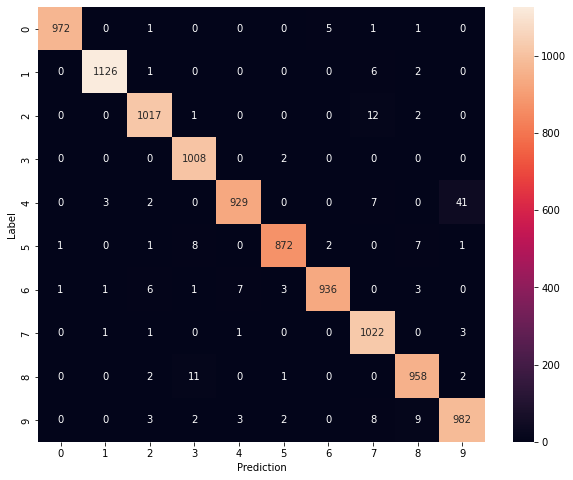

In [34]:
confusion_mtx = tf.math.confusion_matrix(y_test, y_pred)    

import seaborn as sns
import matplotlib.pyplot as plt

class_names = [0,1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()